# Gold & Diamond Weight Estimation Model

This notebook implements a multi-modal ML model to estimate Gold Weight and Diamond Weight based on:
- Image
- Category
- Purity
- Gemstone Presence


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [9]:

DATASET_DIR = "dataset"
CSV_FILE = os.path.join(DATASET_DIR, "data.csv")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40

## 1. Data Loading and Cleaning

In [10]:
# Load CSV
# Since the header might not match all columns (based on inspection), we'll read carefully.
# Based on `head` output: Category, Product URL, Purity, Gold Weight, Diamond Weight, Image Link, [Filename]

try:
    df = pd.read_csv(CSV_FILE, header=None, skiprows=1)
    # Assign columns manually if they don't match standard read
    # Assuming the structure observed: 
    # 0: Category, 1: URL, 2: Purity, 3: Gold Wt, 4: Diamond Wt, 5: Img Link, 6: Filename
    if len(df.columns) == 7:
        df.columns = ["Category", "ProductURL", "Purity", "GoldWeight", "DiamondWeight", "ImageLink", "Filename"]
    elif len(df.columns) == 6:
         # Fallback if the last column is merged or something different happens
        df = pd.read_csv(CSV_FILE)
        # Check if Filename is in 'Image Link' or something else

    print("Data loaded. Shape:", df.shape)
    print(df.head())
except Exception as e:
    print("Error loading CSV:", e)
    # Fallback to standard read
    df = pd.read_csv(CSV_FILE)

# Data Cleaning Function
def clean_weight(val):
    if isinstance(val, str):
        val = val.lower().replace(" g", "").replace(" ct", "").replace("carat", "").strip()
        try:
            return float(val)
        except ValueError:
            return None
    return val

# Clean Weights
if 'GoldWeight' in df.columns:
    df['GoldWeight'] = df['GoldWeight'].apply(clean_weight)
if 'DiamondWeight' in df.columns:
    df['DiamondWeight'] = df['DiamondWeight'].apply(clean_weight)

# Drop rows with missing weights or filename
df = df.dropna(subset=['GoldWeight', 'DiamondWeight', 'Filename'])

print("After cleaning. Shape:", df.shape)
print(df[['Category', 'Purity', 'GoldWeight', 'DiamondWeight', 'Filename']].head())

Data loaded. Shape: (1866, 7)
  Category                                         ProductURL Purity  \
0     ring  https://geer.in/products/delavia-freeform-roun...    14K   
1     ring  https://geer.in/products/zivania-0-5ct-bypass-...    14K   
2     ring  https://geer.in/products/eminence-solitaire-di...    14K   
3     ring  https://geer.in/products/sidorra-0-5ct-surface...    14K   
4     ring  https://geer.in/products/brilliant-round-delic...    14K   

  GoldWeight DiamondWeight                                          ImageLink  \
0     2.09 g       0.25 ct  https://geer.in/cdn/shop/files/GJLR-001_R1.jpg...   
1     3.23 g       0.66 ct  https://geer.in/cdn/shop/files/GJLR-049_R1.jpg...   
2     1.79 g       0.29 ct  https://geer.in/cdn/shop/files/GJLR-117_R1.jpg...   
3     1.74 g        0.6 ct  https://geer.in/cdn/shop/files/GJLR-002_R1.jpg...   
4     1.41 g       0.23 ct  https://geer.in/cdn/shop/files/GJLR-084_R1.jpg...   

          Filename  
0  GJLR-001_R1.jpg  
1  GJLR-

## 2. Image Preprocessing

In [11]:
def load_and_preprocess_image(filename):
    path = os.path.join(DATASET_DIR, filename)
    if not os.path.exists(path):
        return None
    try:
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error loading image {filename}: {e}")
        return None

# Load all images (for this dataset size, loading into memory is likely fine. If large, use generator.)
# Check dataset size first
print(f"Loading {len(df)} images...")

image_data = []
valid_indices = []

for idx, row in df.iterrows():
    img = load_and_preprocess_image(row['Filename'])
    if img is not None:
        image_data.append(img)
        valid_indices.append(idx)

X_images = np.array(image_data)
df_clean = df.loc[valid_indices].reset_index(drop=True)

print("Images loaded. Shape:", X_images.shape)

Loading 1860 images...
Images loaded. Shape: (1860, 224, 224, 3)


## 3. Feature Engineering (Tabular)

In [13]:
# 1. One-Hot Encode Category and Purity
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
purity_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

cat_features = cat_encoder.fit_transform(df_clean[['Category']])
purity_features = purity_encoder.fit_transform(df_clean[['Purity']])

# 2. Gemstone Presence (Constant 1 as per user)
gemstone_features = np.ones((len(df_clean), 1))

# Concatenate Tabular Features
X_tabular = np.hstack([cat_features, purity_features, gemstone_features])

# Targets
y_gold = df_clean['GoldWeight'].values
y_diamond = df_clean['DiamondWeight'].values

print("Tabular features shape:", X_tabular.shape)
print("Categories:", cat_encoder.categories_)
print("Purities:", purity_encoder.categories_)

Tabular features shape: (1860, 8)
Categories: [array(['bangle', 'earring', 'necklace', 'ring'], dtype=object)]
Purities: [array(['14K', '18K', '9K'], dtype=object)]


## 4. Train/Test Split

In [14]:
X_img_train, X_img_val, X_tab_train, X_tab_val, y_gold_train, y_gold_val, y_dia_train, y_dia_val = train_test_split(
    X_images, X_tabular, y_gold, y_diamond, test_size=0.2, random_state=42
)

print("Train set:", X_img_train.shape, X_tab_train.shape)
print("Val set:", X_img_val.shape, X_tab_val.shape)

Train set: (1488, 224, 224, 3) (1488, 8)
Val set: (372, 224, 224, 3) (372, 8)


## 5. Model Architecture

In [15]:
# Image Branch
input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name="image_input")
# Use MobileNetV2 pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_img)
base_model.trainable = False  # Freeze base model initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
img_embedding = Dropout(0.3)(x)

# Tabular Branch
input_tab = Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = Dense(32, activation='relu')(input_tab)
tab_embedding = Dense(16, activation='relu')(y)

# Fusion
concat = Concatenate()([img_embedding, tab_embedding])
z = Dense(64, activation='relu')(concat)
z = Dropout(0.2)(z)

# Outputs
output_gold = Dense(1, name="gold_output")(z)
output_diamond = Dense(1, name="diamond_output")(z)

# Build Model
model = Model(inputs=[input_img, input_tab], outputs=[output_gold, output_diamond])

model.compile(
    optimizer='adam',
    loss={'gold_output': 'mse', 'diamond_output': 'mse'},
    metrics={'gold_output': 'mae', 'diamond_output': 'mae'}
)

model.summary()

/var/folders/bd/4_hz92g94l111ddpvj9_p64c0000gn/T/ipykernel_56873/3812508460.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_img)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,432,178 (9.28 MB)

 Trainable params: 174,194 (680.45 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6. Training

In [16]:
history = model.fit(
    [X_img_train, X_tab_train],
    [y_gold_train, y_dia_train],
    validation_data=([X_img_val, X_tab_val], [y_gold_val, y_dia_val]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - diamond_output_loss: 27.3617 - diamond_output_mae: 2.3690 - gold_output_loss: 29.4510 - gold_output_mae: 3.1848 - loss: 57.2413 - val_diamond_output_loss: 13.9171 - val_diamond_output_mae: 1.9123 - val_gold_output_loss: 30.5259 - val_gold_output_mae: 2.5889 - val_loss: 45.0203
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - diamond_output_loss: 20.2478 - diamond_output_mae: 1.8746 - gold_output_loss: 18.4283 - gold_output_mae: 2.4111 - loss: 38.9582 - val_diamond_output_loss: 10.7164 - val_diamond_output_mae: 1.5949 - val_gold_output_loss: 23.4058 - val_gold_output_mae: 2.3849 - val_loss: 34.6375
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - diamond_output_loss: 17.5267 - diamond_output_mae: 1.7554 - gold_output_loss: 13.5864 - gold_output_mae: 2.1051 - loss: 31.2808 - val_diamond_output_loss: 8.4105 - val_diamond_output_mae: 1.4133 - val_gold_output_loss: 18.3452 - val_gold_output_mae: 2.0919 - val_loss: 27.1555
Epoch

## 7. Evaluation

Predicting on validation set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
--- Gold Weight Metrics ---
MAE: 1.0079
MSE: 3.0981
R2 Score: 0.9499
Accuracy (within 10% or 0.2 units): 36.29%
--- Diamond Weight Metrics ---
MAE: 0.8084
MSE: 2.1985
R2 Score: 0.9020
Accuracy (within 10% or 0.2 units): 30.38%


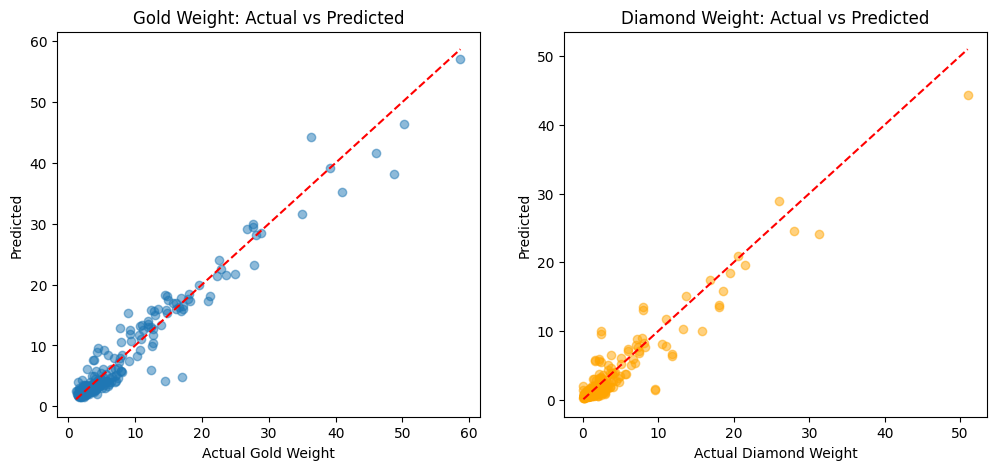

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Predict
print("Predicting on validation set...")
preds = model.predict([X_img_val, X_tab_val])
pred_gold = preds[0].flatten()
pred_diamond = preds[1].flatten()

# 2. Metrics
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Custom Accuracy: % within 10% tolerance
    # Handle division by zero or small values if necessary
    mask = y_true != 0
    diff = np.abs(y_true - y_pred)
    # Avoid division by zero by adding epsilon or handling zeros
    # For robust percentage, maybe within X grams/carats is better
    
    # Tolerance based accuracy (e.g., +/- 10%)
    # For very small values, % difference can be huge. 
    # Let's use a hybrid: within 10% OR within 0.2 units (g or ct)
    accurate_mask = (diff <= (0.1 * y_true)) | (diff <= 0.2)
    accuracy = np.mean(accurate_mask) * 100
    
    print(f"--- {name} Metrics ---")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Accuracy (within 10% or 0.2 units): {accuracy:.2f}%")
    return mae, mse, r2, accuracy

print_metrics(y_gold_val, pred_gold, "Gold Weight")
print_metrics(y_dia_val, pred_diamond, "Diamond Weight")

# 3. Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_gold_val, pred_gold, alpha=0.5)
plt.plot([min(y_gold_val), max(y_gold_val)], [min(y_gold_val), max(y_gold_val)], 'r--')
plt.xlabel("Actual Gold Weight")
plt.ylabel("Predicted")
plt.title("Gold Weight: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(y_dia_val, pred_diamond, alpha=0.5, color='orange')
plt.plot([min(y_dia_val), max(y_dia_val)], [min(y_dia_val), max(y_dia_val)], 'r--')
plt.xlabel("Actual Diamond Weight")
plt.ylabel("Predicted")
plt.title("Diamond Weight: Actual vs Predicted")

plt.show()



In [18]:
# Save Model
model.save("gold_diamond_estimation_model.h5")
print("Model saved as gold_diamond_estimation_model.h5")

Model saved as gold_diamond_estimation_model.h5


In [19]:
# Example Inference
sample_idx = 0
sample_img = np.expand_dims(X_img_val[sample_idx], axis=0)
sample_tab = np.expand_dims(X_tab_val[sample_idx], axis=0)

pred_gold, pred_dia = model.predict([sample_img, sample_tab])

print(f"Correct Gold: {y_gold_val[sample_idx]}, Predicted: {pred_gold[0][0]:.2f}")
print(f"Correct Diamond: {y_dia_val[sample_idx]}, Predicted: {pred_dia[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Correct Gold: 2.2, Predicted: 2.95
Correct Diamond: 0.8, Predicted: 0.62
